# Using ULMfit to analyze the sentiment on tweets

In [1]:
import pandas as pd
import numpy as np
import re
import collections
import matplotlib.pyplot as plt
from fastai.text import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils.multiclass import unique_labels
df=pd.read_csv('airline_sentiment.csv',encoding='latin1')
print(len(df))
df[0:2]

14640


,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,airline_sentiment,airline_sentiment:confidence,negativereason,negativereason:confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_id,tweet_location,user_timezone
0,681448150,False,finalized,3,2/25/15 5:24,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2/24/15 11:35,5.703060e+17,NaN,Eastern Time (US & Canada)
1,681448153,False,finalized,3,2/25/15 1:53,positive,0.3486,NaN,0.0,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2/24/15 11:15,5.703010e+17,NaN,Pacific Time (US & Canada)


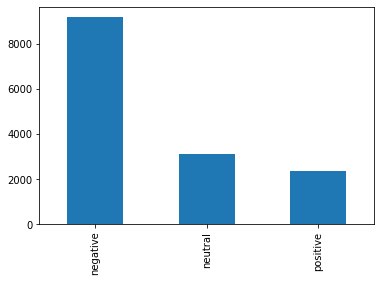

In [2]:
df['airline_sentiment'].value_counts().plot(kind='bar')

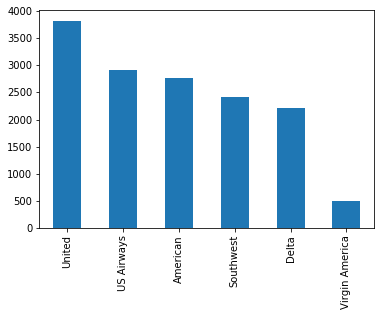

In [3]:
df['airline'].value_counts().plot(kind='bar')

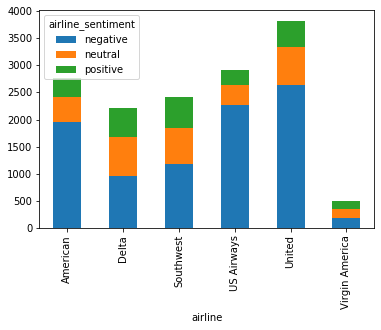

In [4]:
df.groupby(['airline','airline_sentiment']).size().unstack().plot(kind='bar',stacked=True)

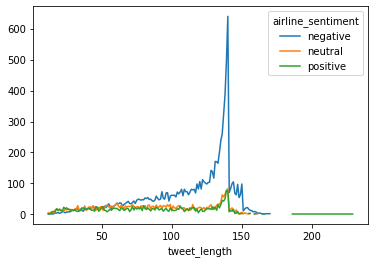

In [5]:
df['tweet_length']=df['text'].apply(len)
df.groupby(['tweet_length','airline_sentiment']).size().unstack().plot(kind='line', stacked=False)

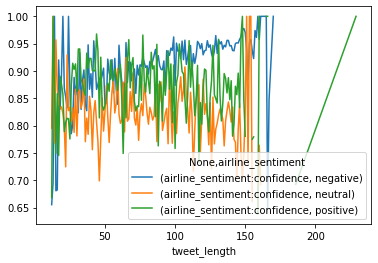

In [6]:
df[['tweet_length','airline_sentiment','airline_sentiment:confidence']].groupby(['tweet_length','airline_sentiment']).mean().unstack().plot(kind='line',stacked=False)

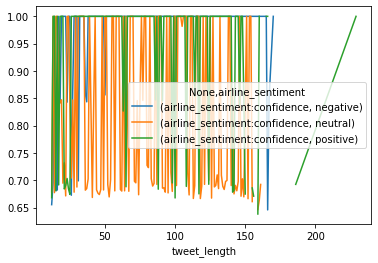

In [7]:
df[['tweet_length','airline_sentiment','airline_sentiment:confidence']].groupby(['tweet_length','airline_sentiment']).median().unstack().plot(kind='line',stacked=False)

Cleaning the text:
1. Special symbols
2. Hashtags
3. Numbers
4. Emojis

In [9]:
df['text'] = df['text'].apply((lambda x: re.sub(r'@\w+', '',x))) # remove mentions

df['text'] = df['text'].apply((lambda x: re.sub('[^a-zA-Z0-9,;:!?.\s]','',x))) # remove emoji

df['text'] = df['text'].apply((lambda x: re.sub(':\)|;\)|:-\)|\(-:|:-D|=D|:P|xD|X-p|\^\^|:-*|\^\.\^|\^\-\^|\^\_\^|\,-\)|\)-:|:\'\(|:\(|:-\(|:\S|T\.T|\.\_\.|:<|:-\S|:-<|\*\-\*|:O|=O|=\-O|O\.o|XO|O\_O|:-\@|=/|:/|X\-\(|>\.<|>=\(|D:', '',x))) # remove more emoji

df['text'] = df['text'].apply((lambda x: re.sub(r'#([^\s]+)', r'\1', x))) # remove hashtags

df['text'] = df['text'].apply((lambda x: ''.join([i for i in x if not i.isdigit()]))) # remove numbers

In [10]:
test_percentage=0.1
df.sort_index(inplace=True)
cutoff=int(test_percentage * df.shape[0])
df[['airline_sentiment','text']][:cutoff].to_csv('tweets_filtered_test.csv',index=False,encoding='utf-8')
df[['airline_sentiment','text']][cutoff:].to_csv('tweets_filtered_train.csv',index=False,encoding='utf-8')
df[['text']][cutoff:].to_csv('tweets_text_only_train.csv',index=False,encoding='utf-8')

In [11]:
#TOKENIZATION
data=TextClasDataBunch.from_csv('.','tweets_filtered_train.csv')
data.show_batch()

text,target
xxbos i xxup just xxup asked xxup my xxup boyfriend xxup to xxup prom xxup over xxup the xxup xxunk xxup on xxup flight xxup he xxup said xxup yes xxrep 4 ! xxup best xxup day xxup ever ! ! ! xxup thank u xxup so xxup much xxrep 6 !,positive
xxbos xxup fuk u xxup us xxup airways xxup with xxup yo xxup shitty xxup chicken xxup xxunk xxup sandwich xxup that xxup so xxup overpriced xxup and u xxup xxunk xxup make xxup me xxup wait xxup in a xxup hr xxup layover xxup fuk u xxup and,negative
"xxbos my wife was on a flt from xxup bro to xxup tul via xxup dfw that was xxmaj cancelled xxmaj flighted . xxmaj bought an xxup swa flight to get her home . xxmaj partial refund , xxup dm me plz ?",negative
xxbos xxmaj missed xxup xxunk flight due to ur xxmaj cancelled xxmaj flightlation . xxmaj xxunk supervisor disgusting . xxmaj now day xxmaj late xxmaj flight . xxmaj no apology or upgrade offer to xxup lhr from xxup ord ? ? ?,negative
xxbos i booked lh via ua . xxmaj however at gate they rebooked me to a xxmaj late xxmaj flightr lh flight . xxmaj now that flight did nt earn pqd for me . xxmaj how do i get it,negative


In [12]:
data.vocab.itos[:10]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 '.']

In [13]:
print(data.train_ds[0][0])
print(data.train_ds[1][0])
print(data.train_ds[2][0])

xxbos and the min line i stood in to drop my bag off ?
xxbos we did check before going to de airport and everything was fine . fail
xxbos i am now following you and see that i am not the only one experiencing and noticing a xxunk downgrade in service post merger


In [14]:
print(data.train_ds[0][0].data[:10])
print(data.train_ds[1][0].data[:10])
print(data.train_ds[2][0].data[:10])

[   2   21   12  178  219   11 2121   24   10  814]
[   2   44   87  168  210  133   10 2405  116   21]
[  2  11  92  48 665  16  21 157  32  11]


In [15]:
##Language Model
bs=24

In [16]:
data_lm=(TextList.from_csv('.','tweets_text_only_train.csv').random_split_by_pct().label_for_lm().databunch(bs=bs))
data_lm.save('data_lm.pkl')

C:\Anaconda\lib\site-packages\fastai\data_block.py:215: UserWarning: `random_split_by_pct` is deprecated, please use `split_by_rand_pct`.
  warn("`random_split_by_pct` is deprecated, please use `split_by_rand_pct`.")


In [17]:
data_lm.show_batch()

idx,text
0,"its act together . xxmaj really disappointed in our change of flight , delayed flights , etc . xxbos rebooked to xxup oma miles from my destination . xxmaj xxunk customer service . i get staff xxunk but come on , this is your business . xxbos xxmaj why have airlines always told us they ca nt open a cabin door once it has been closed ? xxmaj this plane"
1,"xxbos xxmaj also , your phone customer service is almost useless . xxunk xxbos lost bag on next flight . xxmaj did nt have time to load during the hour xxunk from platinum to gold xxbos a day xxmaj late xxmaj flightr , one delayed & one xxmaj cancelled xxmaj flightled flight , i m at a gate with no seat assign . xxmaj lots of standby ppl also waiting"
2,"me pay to check bag . xxmaj then lost bag . ual xxbos i already follow you . xxmaj one of you number agents rebooked me . xxmaj went from a to an a. xxmaj ugh . xxbos good job at xxup cle .. xxup tpa on schedule ... to inches of snow ! xxunk xxbos never fails to have delayed flights xxbos xxmaj yes , myself and about other"
3,"be an xxunk . xxbos accordingly ? u do nt respond at all xxbos the extra care airline . unitedairlines they do nt care . xxmaj trust me . xxmaj there customerservice is non existent . xxmaj they do nt have xxbos xxmaj another unfortunate case of bad luck , usually maintenance issue . xxmaj they are now xxunk planes to xxup ont , will get in xxmaj late xxmaj"
4,"hours . xxmaj thanks xxbos xxmaj we invite to xxmaj fallow learn about our activities . xxmaj xxunk xxmaj programs of xxmaj health by xxunk xxmaj family . xxmaj we r xxunk xxbos xxmaj very nice at xxup lhr , congrats , but i m sticking with xxup xxunk . xxbos how long will it take for miles that i xxunk they had expired to show up ? i recieved"


The model gathers different types of information at each layer. Thus gradual unfreezing of layers is done so as to get efficient results at the end. First cycle learning can be less accurate but improves at every next learning cycle.

In [18]:
learn=language_model_learner(data_lm,AWD_LSTM,drop_mult=0.3) ##AWD_LSTM is a pretrained model for text processing

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


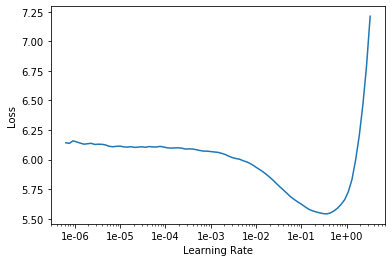

In [19]:
learn.lr_find()
learn.recorder.plot()

In [20]:
learn.fit_one_cycle(1,1e-2,moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.307213,4.044005,0.238971,11:49


In [21]:
learn.save('fit_head')

In [22]:
learn.unfreeze()

In [23]:
learn.fit_one_cycle(10,1e-3,moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.906275,3.913047,0.259261,30:23
1,3.788323,3.831748,0.268435,29:52
2,3.608020,3.774097,0.276103,25:15
3,3.316658,3.781957,0.279587,25:31
4,2.953305,3.869662,0.274755,28:58
5,2.549149,4.004998,0.269345,27:51
6,2.211620,4.125408,0.264531,26:21
7,1.950174,4.244355,0.261590,28:59
8,1.771907,4.315443,0.259454,31:43
9,1.692801,4.336259,0.258508,27:36


In [24]:
learn.save('fine_tuned')

In [25]:
learn.save_encoder('fine_tuned_enc')

In [34]:
##The collected data acts as vocabulary to train the learning model on dependent and independent variables
data_clas = TextClasDataBunch.from_csv('.', 'tweets_filtered_train.csv', vocab=data_lm.train_ds.vocab,min_freq=1, bs=24)
data_clas.save('data_clas.pkl')
data_clas.show_batch()

text,target
xxbos xxup where xxup is xxup my xxup fucking xxup bag ? ! ? ! xxmaj where the fuck is my fucking bag ? ? ? xxup tell xxup me xxup now xxup or xxup give xxup me a xxup number xxup to xxup call a xxup human . xxup xxunk,negative
"xxbos xxup ua from xxup ric , xxup ua from xxup ord , & xxup ua from xxup den xxup all xxup delayed for xxunk issues . xxmaj way to go , you re xxunk . ! xxmaj but no hotels",negative
xxbos xxmaj need your help . i m moving to xxup dc & i want to book a one way fare on your website . xxmaj it wo nt seem to let me . xxmaj am i missing something ?,negative
xxbos i do nt like being lied to . xxmaj no bad weather in dc md va . i ve been stuck in xxup ca all day and should ve been home by now . xxmaj you owe me .,negative
xxbos xxmaj all flts to xxup jfk xxmaj cancelled xxmaj flightled xxmaj thx to xxup ur agent at xxup sfo i m rebooked on xxup ua . xxmaj did nt get name . xxmaj she was awesome ! xxunk xxunk,negative


In [36]:
learn=text_classifier_learner(data_clas,AWD_LSTM,drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (10540 items)
x: TextList
xxbos thanks for the quick response . xxmaj should i call daily it wait the days .,xxbos really need help asap , so please make it quick . xxmaj thx .,xxbos hello i am flying first class and am behind people on zone xxrep 5 ! xxmaj pls pass on to app dept you should board st class first,xxbos you guys are complete ass,xxbos i do nt know my flight details bc i need to xxunk some options which i m unable to do bc the site wo nt let me . xxmaj seems to be xxunk
y: CategoryList
positive,negative,negative,negative,negative
Path: .;

Valid: LabelList (2636 items)
x: TextList
xxbos okay . i just sent it .,xxbos xxmaj not okay . xxmaj since you could nt put me on an earlier flight , i had to buy my own ticket on another airline .,xxbos flight out of xxmaj vegas to xxup dfw . xxmaj cancelled xxmaj flightled xxmaj sunday and xxmaj monday , no xxunk today !,xxbos message me if you want to issue a refund so someone else

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


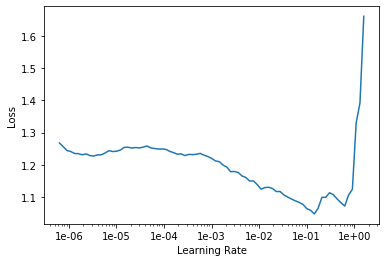

In [37]:
learn.lr_find()
learn.recorder.plot()

In [38]:
learn.fit_one_cycle(1,2e-2,moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.694380,0.562391,0.776935,08:05


In [39]:
learn.save('first')
learn.freeze_to(-2)
learn.fit_one_cycle(1,slice(1e-2/(2.6**4),1e-2),moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.636786,0.504006,0.804628,12:19


In [40]:
learn.save('second')

In [41]:
learn.freeze_to(-3)
learn.fit_one_cycle(1,slice(5e-3/(2.6**4),5e-3),moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.582245,0.468607,0.820182,19:59


In [42]:
learn.unfreeze()
learn.fit_one_cycle(3,slice(1e-3/(2.6**4),1e-3),moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.474653,0.454200,0.819044,30:31
1,0.444558,0.463647,0.817906,33:05
2,0.416172,0.467744,0.820182,36:00


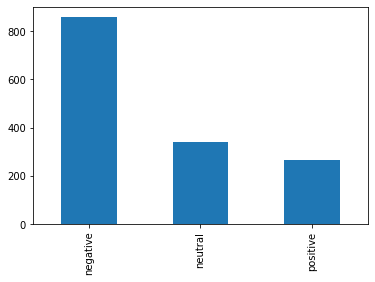

In [43]:
#Plotting the test dataset
test_df=pd.read_csv('tweets_filtered_test.csv',encoding='utf-8')
test_df['airline_sentiment'].value_counts().plot(kind='bar')

In [46]:
##Apply the predict method to produce prediction
test_df['pred_sentiment']=test_df['text'].apply(lambda row: str(learn.predict(row)[0]))
print('test accuracy:',accuracy_score(test_df['airline_sentiment'],test_df['pred_sentiment']))

C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is in

C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is in

C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is in

C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is in

C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is in

C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is in

C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is in

C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is in

C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is in

C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is in

C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is in

C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is in

C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is in

C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is in

C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is in

C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is in

C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is in

C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is in

C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is in

C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is in

C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is in

C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is in

C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is in

C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is in

C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is in

C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is in

C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is in

C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is in

C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is in

C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is in

C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is in

C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is in

C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is in

C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is in

C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is in

C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is in

C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is in

C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is in

C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is in

C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is in

C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is in

test accuracy: 0.7984972677595629


C:\Anaconda\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


We observe that an accuracy of about 0.79 is achieved

In [47]:
test_df[:20]

,airline_sentiment,text,pred_sentiment
0,neutral,What said.,neutral
1,positive,plus youve added commercials to the experienc...,negative
2,neutral,I didnt today... Must mean I need to take ano...,negative
3,negative,its really aggressive to blast obnoxious ente...,negative
4,negative,and its a really big bad thing about it,positive
5,negative,seriously would pay a flight for seats that ...,negative
6,positive,"yes, nearly every time I fly VX this ear worm...",negative
7,neutral,Really missed a prime opportunity for Men Wit...,negative
8,positive,"Well, I didntbut NOW I DO! D",positive
9,positive,"it was amazing, and arrived an hour early. Yo...",positive


In [52]:
def plot_confusion_matrix(y_true,y_pred, classes, normalize=False,title=None,cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title='normalized confusion matrix'
        else:
            title='confusion matrix, without normalization'
    cm=confusion_matrix(y_true,y_pred)
    fig,ax=plt.subplots()
    im=ax.imshow(cm,interpolation='nearest',cmap=cmap)
    ax.figure.colorbar(im,ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        xticklabels=classes,yticklabels=classes,
        title=title,
        ylabel='true label',
        xlabel='predicted label')
    plt.setp(ax.get_xticklabels(),rotation=45,ha='right',rotation_mode='anchor')
    fmt='.2f' if normalize else 'd'
    thresh=cm.max()/2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j,i,format(cm[i,j],fmt),ha='center',va='center',color='white' if cm[i,j]>thresh else 'black')
    fig.tight_layout()
    return ax

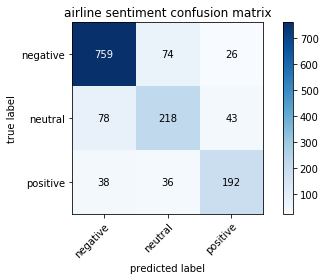

In [53]:
plot_confusion_matrix(test_df['airline_sentiment'],test_df['pred_sentiment'],classes=['negative','neutral','positive'],title='airline sentiment confusion matrix')
plt.show()

In [54]:
test_df.loc[(test_df['airline_sentiment']=='positive')&(test_df['pred_sentiment']=='negative')]

,airline_sentiment,text,pred_sentiment
1,positive,plus youve added commercials to the experienc...,negative
6,positive,"yes, nearly every time I fly VX this ear worm...",negative
64,positive,love all three but you really cant beat th...,negative
81,positive,Ive applied more then once to be a member of ...,negative
114,positive,come back to PHL already. We need you to take...,negative
118,positive,your beautiful frontend design is down right ...,negative
119,positive,Love the team running Gate E at LAS tonight. ...,negative
307,positive,I mean. Probably inappropriate while on board...,negative
358,positive,"just promoting the product is all, had a prob...",negative
369,positive,got it squared away. Someone picked up as soo...,negative
